In [1]:
import pandas as pd
from dotenv import load_dotenv
import os
import time
import json
import requests
import matplotlib.pyplot as plt

In [2]:
# Get the fred api key
load_dotenv("keys.env")
fred_api_key = os.getenv("FRED_API_KEY")

In [3]:
# Store FRED data in a dictionary
df_dict = {"income": "NCPCPI", "house": "NCSTHPI", "minimum_wage": "STTMINWGNC", "cpi": "CUUR0000SEHA", "mortgage": "MORTGAGE30US", "insurance_premiums": "PCU9241269241261", "population": "NCPOP"}

for key, value in df_dict.items():
    try:
        data = requests.get(f"https://api.stlouisfed.org/fred/series/observations?series_id={value}&api_key={fred_api_key}&file_type=json").json()
        df = pd.DataFrame(data['observations'])
        df_dict[key] = df
    except:
        print(f"Problem getting data for {key}: {value}")


In [4]:
df = df_dict['cpi']
df.head()
df.info()
df.isnull().sum()
# df['value'] = df['value'].astype(float)
# df['date'] = df['date'].astype('datetime64[ns]')
# df.head()
# df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   realtime_start  1315 non-null   object
 1   realtime_end    1315 non-null   object
 2   date            1315 non-null   object
 3   value           1315 non-null   object
dtypes: object(4)
memory usage: 41.2+ KB


realtime_start    0
realtime_end      0
date              0
value             0
dtype: int64

In [9]:
# Read the CSV files, and store dataframes. Some clean up as well.
def percent_change_column(df):
    """Create a column that shows how much since the very first date"""
    df['changed'] = (df['value'].pct_change() * 100).cumsum().fillna(0)
    return df

def locate_year_df(df):
    """Take a df and return the dataframe within the year 1980-2023"""
    df = df.loc[(df['date'] >= "1980-01-01") & (df['date'] <= "2023-12-31")].reset_index(drop=True)
    return df

def conversion_date_value(df):
    """Convert the columns date to datetime and value to float"""
    conversions = {
    'date': 'datetime64[ns]',
    'value': float
    }

    # Drop any rows where the value column is non numeric
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df = df.drop(columns=['realtime_start', 'realtime_end']).astype(conversions)
    return df

data_dict = {}
for key, value in df_dict.items():
    df_key = f"{key}_df"
    try:
        data_dict[(df_key)] = percent_change_column(locate_year_df(conversion_date_value(value)))
    except:
        print(f"Error with {key} dataset.")

unemployment_rate_df = pd.read_csv('data/UnemploymentRate.csv').set_index(['Year', 'Month'], drop=True)


In [10]:
# Display the DataFrames first 2 and last 2 rows
for key, value in data_dict.items():
    clean_key = key.replace("_", " ")
    print(clean_key)
    display(pd.concat([value.head(2), value.tail(2)]))

income df


,date,value,changed
0,1980-01-01,8350.0,0.000000
1,1981-01-01,9309.0,11.485030
42,2022-01-01,58125.0,200.484844
43,2023-01-01,60484.0,204.543339


house df


,date,value,changed
0,1980-01-01,100.00,0.000000
1,1980-04-01,98.91,-1.090000
174,2023-07-01,650.12,189.850435
175,2023-10-01,649.30,189.724304


minimum wage df


,date,value,changed
0,1980-01-01,2.75,0.000000
1,1981-01-01,2.90,5.454545
42,2022-01-01,7.25,104.031762
43,2023-01-01,7.25,104.031762


cpi df


,date,value,changed
0,1980-01-01,77.800,0.000000
1,1980-02-01,78.400,0.771208
526,2023-11-01,408.838,166.273353
527,2023-12-01,410.606,166.705799


mortgage df


,date,value,changed
0,1980-01-04,12.85,0.000000
1,1980-01-11,12.90,0.389105
2294,2023-12-21,6.67,-33.549599
2295,2023-12-28,6.61,-34.449149


insurance premiums df


,date,value,changed
0,1998-06-01,100.000,0.000000
1,1998-07-01,99.900,-0.100000
305,2023-11-01,208.447,73.879194
306,2023-12-01,209.134,74.208774


population df


,date,value,changed
0,1980-01-01,5898.980,0.000000
1,1981-01-01,5956.653,0.977677
42,2022-01-01,10695.965,60.060587
43,2023-01-01,10835.491,61.365060


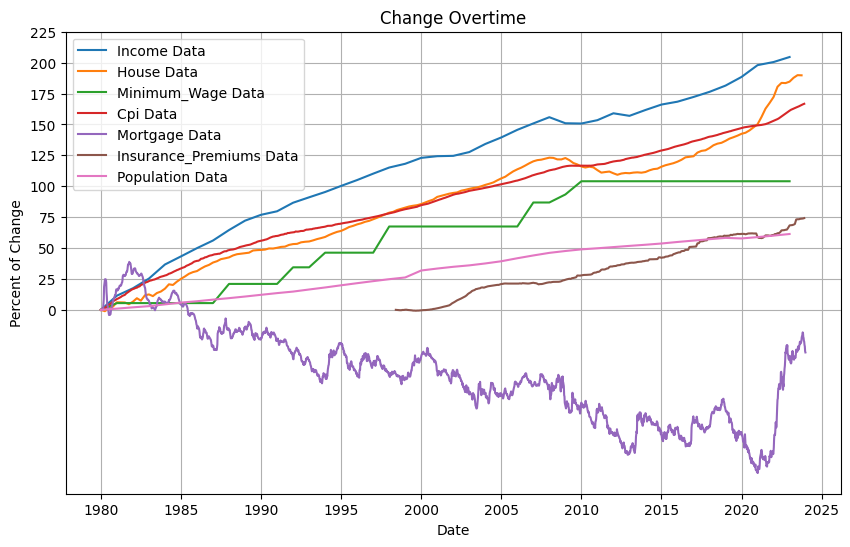

In [16]:
# Creating a visualization for income data
# Assuming df_income, df_house, and df_min_wage are your DataFrames
plt.figure(figsize=(10, 6))

# Plot each DataFrame
for key, value in data_dict.items():
    plt.plot(value['date'], value['changed'], label=f'{key.replace("_df", "").title()} Data')

plt.title("Change Overtime")
plt.ylabel("Percent of Change")
plt.xlabel("Date")
plt.legend()
plt.yticks(range(0, 250, 25))
plt.grid()
plt.savefig('graphs/change_overtime.png')
plt.show()
